# Final Project Graph ML
Grace Hughes

## Purpose of Project

The purpose of this project was to use Graph machine learning to pair different, unlikely foods into new combinations. The most prevalent use of graph ML is to find connections between different nodes and use those connections to introduce new ideas (recommendation algorithms, PageRank, etc.) Of these algorithms, most cater to applications in healthcare, advertising, and other commercial uses, but I wanted to do something different. I spend a lot of my free time experimenting in the kitchen and challenging myself to try new things. 

After working on this project, I did have to scale back my expectations due to my limited experience. So, instead of an algorithm to tell me novel combinations, the algorithm instead is designed to recommend ingredients to add with others based on pre-existing recipes and data. When I'm making up a recipe in the kitchen (often), I find myself wondering what else I could add to it to make it more interesting. This algorithm serves that purpose.


## Importing Data

The data used for this lab is from FooDB, one of the largest food databases for public use. It has 1024 different foods and tens of thousands of compounds that are found in foods. I also use a recipe database found on Kaggle (https://www.kaggle.com/datasets/shuyangli94/food-com-recipes-and-user-interactions). This dataset has over 180,000 recipes.

From these two datasets, I'm using the ingredient names, food groups, and recipes to map nodes and edges within the graph.

In [1]:
import pandas as pd

In [2]:
food_db = pd.read_csv("Food.csv")

In [3]:
food_db.head(2)

,id,name,name_scientific,description,itis_id,wikipedia_id,picture_file_name,picture_content_type,picture_file_size,picture_updated_at,...,food_type,created_at,updated_at,creator_id,updater_id,export_to_afcdb,category,ncbi_taxonomy_id,export_to_foodb,public_id
0,1,Angelica,Angelica keiskei,Angelica is a genus of about 60 species of tal...,NaN,Angelica,1.jpg,image/jpeg,111325.0,2012-04-20 09:29:57 UTC,...,Type 1,2011-02-09 00:37:14 UTC,2019-05-14 18:04:13 UTC,NaN,2.0,False,specific,357850.0,True,FOOD00001
1,2,Savoy cabbage,Brassica oleracea var. sabauda,Savoy cabbage (Brassica oleracea convar. capit...,NaN,Savoy cabbage,2.jpg,image/jpeg,155178.0,2012-04-20 09:39:54 UTC,...,Type 1,2011-02-09 00:37:15 UTC,2019-05-14 18:04:13 UTC,NaN,NaN,False,specific,1216010.0,True,FOOD00002


In [4]:
recipe = pd.read_csv("RAW_recipes.csv")
recipe.head(2)

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6


In [5]:
content = pd.read_csv("Content.csv", low_memory=False)
content.head(2)

,id,source_id,source_type,food_id,orig_food_id,orig_food_common_name,orig_food_scientific_name,orig_food_part,orig_source_id,orig_source_name,...,citation_type,creator_id,updater_id,created_at,updated_at,orig_method,orig_unit_expression,standard_content,preparation_type,export
0,1,1,Nutrient,4,29,Kiwi,Actinidia chinensis PLANCHON [Actinidiaceae],Fruit,FAT,FAT,...,DATABASE,NaN,NaN,2014-11-05 13:42:11 UTC,2019-12-11 20:23:57 UTC,NaN,NaN,1955.00,raw,0
1,2,1,Nutrient,6,53,Onion,Allium cepa L. [Liliaceae],Bulb,FAT,FAT,...,DATABASE,NaN,NaN,2014-11-05 13:42:11 UTC,2019-12-11 20:23:57 UTC,NaN,NaN,1853.95,raw,0


## Creating the Graph

The graph for this lab has three types of nodes: Foods, Food Groups, and Recipes. The edges between the nodes are between foods and the food group they're in, and between recipes and the ingredients used in them. To create the graph, I used networkx because it easy to use with graph algorithms. 

In [6]:
import networkx as nx
nx.__version__

'2.6.3'

In [7]:
food_graph = nx.Graph()

### Adding food and group nodes/edges

First, I want to add two types of nodes: the individual foods and food groups. I also add edges between them if the ingredient is in that food group.

In [8]:
avoid = ["salt", "water"]

for index, row in food_db.iterrows():
    if(row['name'].lower() not in avoid):
        food_graph.add_node(row['name'].lower(), label = "FOOD") 
        food_graph.add_node(row['food_subgroup'], label = "GROUP")
        food_graph.add_edge(row['name'].lower(), row['food_subgroup'], label = "IN_GROUP")

### Adding Food Part and Source Type nodes/edges to graph

Next, I add the data from compounds to the graph. This includes nodes for food parts and source types. Edges are also added between foods that have these types.

In [9]:
ingreds = dict()
for index, row in food_db.iterrows():
    ingreds[row['name'].lower()] = []

In [10]:
for index, row in content.iterrows():
    if type(row['orig_food_common_name']) == str:
        food = row['orig_food_common_name'].lower()
        if food in ingreds:
            food_graph.add_node(row['orig_food_part'], label="FOOD_PART")
            food_graph.add_edge(row['orig_food_part'], food, label='PART')
        
            food_graph.add_node(row['source_type'], label='SOURCE_TYPE')
            food_graph.add_edge(row['source_type'], food, label='SOURCE')
        

### Adding Recipe nodes/edges to graph

Next up is adding the recipe nodes and edges. To do this, I loop through all the recipes in the database and add each as their own node under its id. Then, I loop through the ingredients listed and add an edge to every ingredient found in the recipe.

In [11]:
r_d = dict()
for index, row in recipe.iterrows():
    r_d[str(row['id'])] = []

In [12]:
spec_char = ['\[', '\]', '\'']
for index, row in recipe.iterrows():  #Iterates through each recipe
    food_graph.add_node(row['id'], label="RECIPE")
    ings = row['ingredients'].split(',')
    
    for i in ings: #iterates through each ingredient in recipe
        i = i.strip(" \[\]\'").lower()
        if(i in ingreds): #ingredient i in recipe
            food_graph.add_edge(row["id"], i, label="IN_RECIPE")

#r_d is filtered recipe dict, where each recipe has a list of ingredients that exist in ingreds       

In [13]:
r_list = list(r_d.items()) #list version of r_d

### Plotting

Now that all the necessary nodes and edges have been added to the graph, we're able to take a look at what the graph looks like. Since there is a large network of edges, I am only showing one food, papaya, and its edges.

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline

def get_all_adj_nodes(list_in):
    sub_graph=set()
    for m in list_in:
        sub_graph.add(m)
        for e in food_graph.neighbors(m):        
                sub_graph.add(e)
    return list(sub_graph)
def draw_sub_graph(sub_graph, title):
    subgraph = food_graph.subgraph(sub_graph)
    colors=[]
    for e in subgraph.nodes():
        if food_graph.nodes[e]['label']=="FOOD":
            colors.append('orange')
        elif food_graph.nodes[e]['label']=="GROUP":
            colors.append('red')
        elif food_graph.nodes[e]['label']=="RECIPE":
            colors.append('blue')
        elif food_graph.nodes[e]['label']=="FOOD_PART":
            colors.append('yellow')
        elif food_graph.nodes[e]['label']=="SOURCE_TYPE":
            colors.append('green')

    #plt.figure(figsize=(8,8))
    nx.draw_networkx(subgraph, with_labels=True, font_weight = 'bold' ,node_color=colors, edge_color="gray", label=subgraph.nodes())
    plt.title(title + "\n\n Orange = Food, Red = Group, Blue = Recipe \n Yellow = Food Part, Green = Source Type")
    
    plt.show()

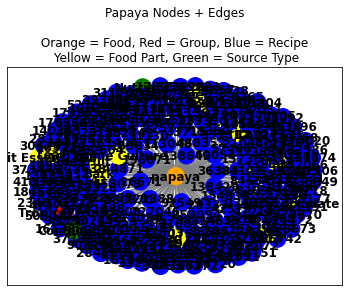

In [40]:
list_in=["papaya"]
sub_graph = get_all_adj_nodes(list_in)
title = "Papaya Nodes + Edges"
draw_sub_graph(sub_graph, title)

## Recommendation algrorithm

With the completed graph, we are able to get recommended ingredients that are similar to the inputted ingredient. This is done by first getting all of the node's neighbors (other nodes it has edges to). Then, it looks into their neighbors to see which foods share that neighbor. With this information, the ademic-adar index is calculated. This index was created to predict links in a social network based on how many links it shares with other nodes. The number itself is the inverse logarithmic degree centrality of the shared neighbors. A higher index shows a higher corrolation between the nodes.

In [16]:
import math
import numpy as np

In [24]:
#algorithm adapted from https://www.kaggle.com/code/yclaudel/recommendation-engine-with-networkx/notebook
def get_recommendation(root):
    commons_dict = {}
    for e in food_graph.neighbors(root):
        for e2 in food_graph.neighbors(e):
            if e2==root:
                continue
            if ('label' in food_graph.nodes[e2]) and (food_graph.nodes[e2]['label']=="FOOD"):
                commons = commons_dict.get(e2)
                if commons==None:
                    commons_dict.update({e2 : [e]})
                else:
                    commons.append(e)
                    commons_dict.update({e2 : commons})
    food=[]
    weight=[]
    for key, values in commons_dict.items():
        w=0.0
        for e in values:
            w=w+1/math.log(food_graph.degree(e))
        food.append(key) 
        weight.append(w)
    
    result = pd.Series(data=np.array(weight),index=food)
    result.sort_values(inplace=True,ascending=False)        
    return result;

## Results

Now we get to test the algorithm. 

In [25]:
recommend = "papaya"
result = get_recommendation(recommend)
print("\n-- Ingredients to use with ", recommend, "--\n")
print(result[0:10]) 


-- Ingredients to use with  papaya --

mango         40.161473
sugar         33.973846
honey         29.470126
banana        23.460476
lime          21.058116
olive oil     15.348190
pineapple     12.937924
red onion     11.718729
lemon          9.297400
strawberry     8.407449
dtype: float64


So, if you're making a recipe with papaya, these are the 10 ingredients most recommended to add to it!